# Home Value

## Goal:

- Discover drivers of home value
- Use drivers of home value to predict home values.

## Imports

In [1]:
import pandas as pd
import os
import seaborn as sns
import env
import wrangle_reg as acq
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from termcolor import colored
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor
from pydataset import data
from sklearn.linear_model import LassoLars
from scipy.stats import pearsonr
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings("ignore")

### Acquire

- Data acquired from SQL Database
- It contained 52442 rows and 8 columns before cleaning
- Each row represents a home from the zillow database
- Each column represents a feature of those homes

### Prepare

 - Identify nulls/Nan and replace them with the mean or get rid of that column if there are too many nulls/Nans
 - Identify columns with duplicate values and get rid of them
 - Change column names to make them readable
 - Split data between X and Y
 - Identify outliers, and get rid of them

In [2]:
df = acq.get_zillow_data()

csv file found and loaded


## A brief look at the data

In [3]:
df.head()

,bathroomcnt,bedroomcnt,fips,garagecarcnt,yearbuilt,lotsizesquarefeet,taxvaluedollarcnt,transactiondate
0,3.5,4.0,6059.0,2.0,1998.0,4506.0,1023282.0,2017-01-01
1,1.0,2.0,6111.0,1.0,1967.0,12647.0,464000.0,2017-01-01
2,2.0,3.0,6059.0,2.0,1962.0,8432.0,564778.0,2017-01-01
3,3.0,4.0,6037.0,NaN,1970.0,13038.0,145143.0,2017-01-01
4,3.0,4.0,6037.0,NaN,1950.0,63000.0,773303.0,2017-01-01


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52442 entries, 0 to 52441
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bathroomcnt        52442 non-null  float64
 1   bedroomcnt         52442 non-null  float64
 2   fips               52442 non-null  float64
 3   garagecarcnt       18015 non-null  float64
 4   yearbuilt          52326 non-null  float64
 5   lotsizesquarefeet  52073 non-null  float64
 6   taxvaluedollarcnt  52441 non-null  float64
 7   transactiondate    52442 non-null  object 
dtypes: float64(7), object(1)
memory usage: 3.6+ MB


### Prepare

In [5]:
df = acq.prep_zillow(df)

In [6]:
df.head()

,bathrooms,bedrooms,county,car garage,yr built,lotsqft,value,date
0,3.5,4.0,Orange County,2.0,1998.0,4506.0,1023282.0,2017-01-01
1,1.0,2.0,Ventura,1.0,1967.0,12647.0,464000.0,2017-01-01
2,2.0,3.0,Orange County,2.0,1962.0,8432.0,564778.0,2017-01-01
8,2.5,3.0,Orange County,2.0,1980.0,1199.0,319668.0,2017-01-02
9,2.5,3.0,Ventura,2.0,2004.0,3445.0,198054.0,2017-01-02


In [7]:
df = acq.remove_outliers(df, threshold=3)

In [8]:
#all columns for the manipulated data, and first five values
df.head()

,bathrooms,bedrooms,county,car garage,yr built,lotsqft,value,date
0,3.5,4.0,Orange County,2.0,1998.0,4506.0,1023282.0,2017-01-01
1,1.0,2.0,Ventura,1.0,1967.0,12647.0,464000.0,2017-01-01
2,2.0,3.0,Orange County,2.0,1962.0,8432.0,564778.0,2017-01-01
8,2.5,3.0,Orange County,2.0,1980.0,1199.0,319668.0,2017-01-02
9,2.5,3.0,Ventura,2.0,2004.0,3445.0,198054.0,2017-01-02


## A summary of the data

In [9]:
#statistical values of dataset
df.describe()

,bathrooms,bedrooms,car garage,yr built,lotsqft,value
count,17950.000000,17950.000000,17950.000000,17950.000000,1.795000e+04,1.795000e+04
mean,2.528635,3.530529,1.950251,1975.315933,8.772642e+03,5.844369e+05
std,0.901055,0.866508,0.547818,18.178490,1.784418e+04,5.770407e+05
min,0.000000,0.000000,0.000000,1880.000000,2.360000e+02,9.242000e+03
25%,2.000000,3.000000,2.000000,1963.000000,5.200000e+03,2.831105e+05
50%,2.500000,3.000000,2.000000,1973.000000,6.689500e+03,4.680000e+05
75%,3.000000,4.000000,2.000000,1989.000000,8.442000e+03,7.073600e+05
max,8.500000,9.000000,14.000000,2016.000000,1.323788e+06,1.319825e+07


In [10]:
df.head()

,bathrooms,bedrooms,county,car garage,yr built,lotsqft,value,date
0,3.5,4.0,Orange County,2.0,1998.0,4506.0,1023282.0,2017-01-01
1,1.0,2.0,Ventura,1.0,1967.0,12647.0,464000.0,2017-01-01
2,2.0,3.0,Orange County,2.0,1962.0,8432.0,564778.0,2017-01-01
8,2.5,3.0,Orange County,2.0,1980.0,1199.0,319668.0,2017-01-02
9,2.5,3.0,Ventura,2.0,2004.0,3445.0,198054.0,2017-01-02


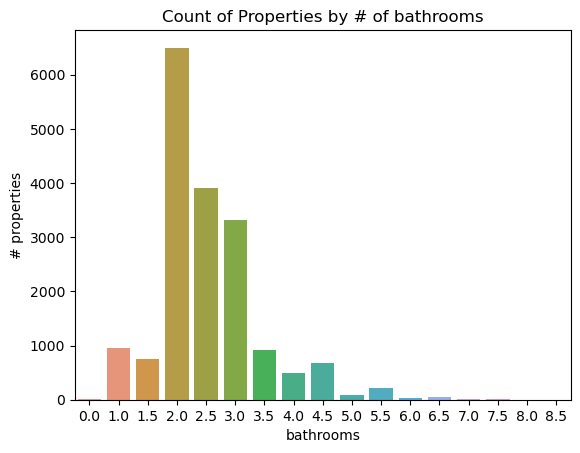

In [11]:
#the vast majority of bathrooms have 1.5 to 3.5 bathrooms
sns.countplot(data=df, x=df.bathrooms)
plt.xlabel('bathrooms')
plt.ylabel('# properties')
plt.title('Count of Properties by # of bathrooms')
plt.show()

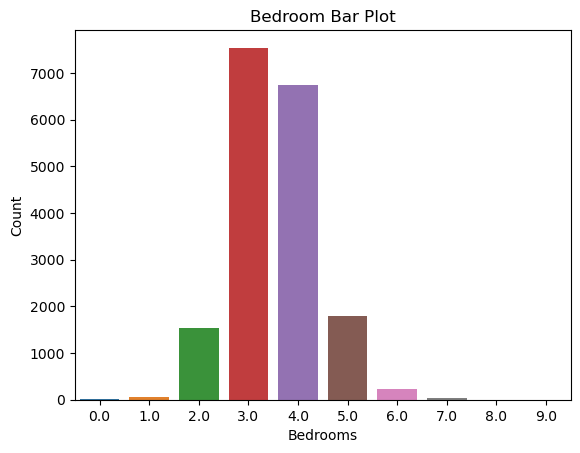

In [12]:
#Most homes have 2 to 5 bedrooms

sns.countplot(data=df, x='bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
plt.title('Bedroom Bar Plot')
plt.show()

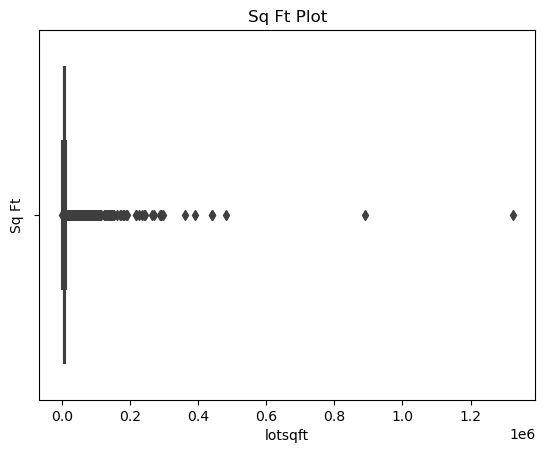

In [13]:
sns.boxplot(data=df, x='lotsqft')
plt.ylabel('Sq Ft')
plt.title('Sq Ft Plot')
plt.show()

In [14]:
df = acq.prep_z(df)

### Explore

##### Answer the following questions:

In [15]:
train, validate, test = acq.train_split_data(df)


    train -> (10052, 5)
    validate -> (4308, 5)
    test -> (3590, 5)


In [16]:
#Split dataset into two components
X, Y = acq.split_data_axis(df)

# splitting X, Y data into train, validate, and test
X_train, X_validate, X_test, y_train, y_validate, y_test = acq.train_validate_test_split(X, Y)


    X_train -> (10052, 4)'
    X_validate -> (4308, 4)'
    X_test -> (3590, 4)


### Does the number of bedrooms a home has impact home value?

$H_{0}$: The number of bedrooms a home has does not impact the value of the home.

$H_{a}$: The number of bedrooms a home has does impact the value of the home.


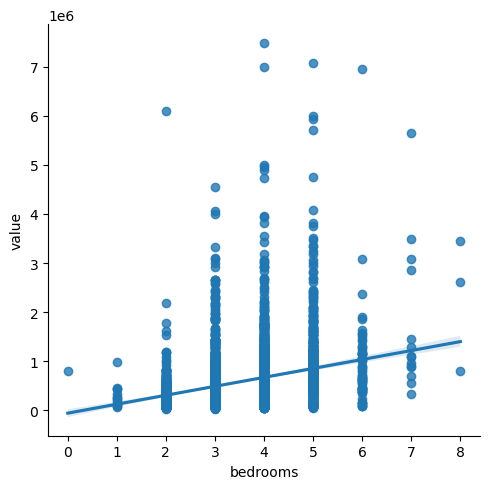

In [17]:
acq.bed_plot_lmplot(train)

In [18]:
# In order to pull just the bedrooms and value I turned their columns into individual dataframes
train_bed = pd.DataFrame(train.bedrooms, train.value)
bedrooms = train['bedrooms']
value = train['value']

In [19]:
# I calculated the correlation value using pearson since they are continuous values

correlation, p_value = pearsonr(bedrooms, value)
correlation, p_value
print(f'p is is less than alpha at {p_value} therefore the relationship is significant')


p is is less than alpha at 1.4786338764590046e-180 therefore the relationship is significant


#### The relationship between home value and the number of bedrooms a home has is pretty weak.

### Does the number of bathrooms a home has impact home value

$H_{0}$: The number of bathrooms a home has does not impact the value of the home.

$H_{a}$: The number of bathrooms a home has does not impac the vale of the home.

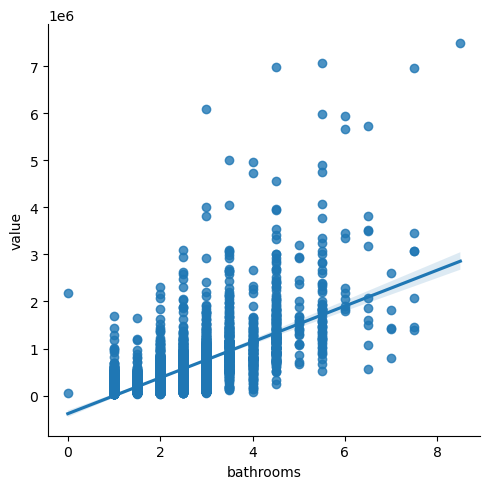

In [20]:
# Visualizing the relationship between bathroom and home value
acq.bath_plot_lmplot(train)

In [21]:
# Pulled bathrooms from train dataset in order to run a correlation test on it
bathrooms = train['bathrooms']

In [22]:
# Ran a correlation test using pearsonr and 
correlation, p_value = pearsonr(bathrooms, value)
correlation, p_value
print(f'p is is less than alpha at {p_value} therefore the relationship is significant')


p is is less than alpha at 0.0 therefore the relationship is significant


#### There is a relatively strong relationhip between bathrooms and home value.


### Does the lot square footage of the property impact the home value

$H_{0}$: The lot square footage of the property does not impact home value.

$H_{a}$: The lot square footage of the property does impact the home value.

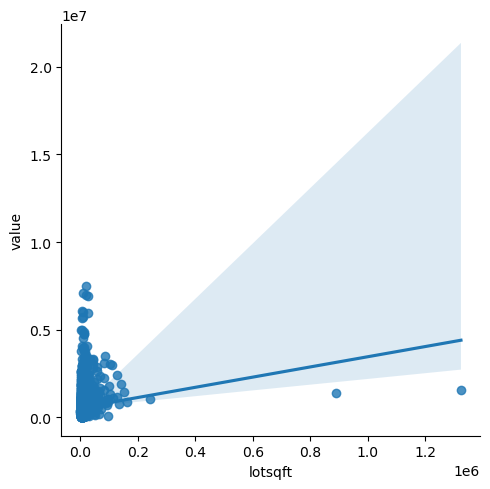

In [23]:
acq.lot_sf_plot_lmplot(train)

In [24]:
lotsqft = train['lotsqft']

In [25]:
correlation, p_value = pearsonr(lotsqft, value)
correlation, p_value
print(f'p is is less than alpha at {p_value} therefore the relationship is significant')


p is is less than alpha at 1.0374374936494262e-50 therefore the relationship is significant


## Summary of Exploration: 

- Bedroom count had a weak correlation with value, with p further 
- Bathroom had the strongest correlation with value at .6, with a p value of 0
- Lotsqft had the weakest correlation with value at .14

## Modeling
- RMSE chosen as evaluation metric 
    - 573364.10 in error, with R2 of 0
- Baseline predicition value is $584,945.76.

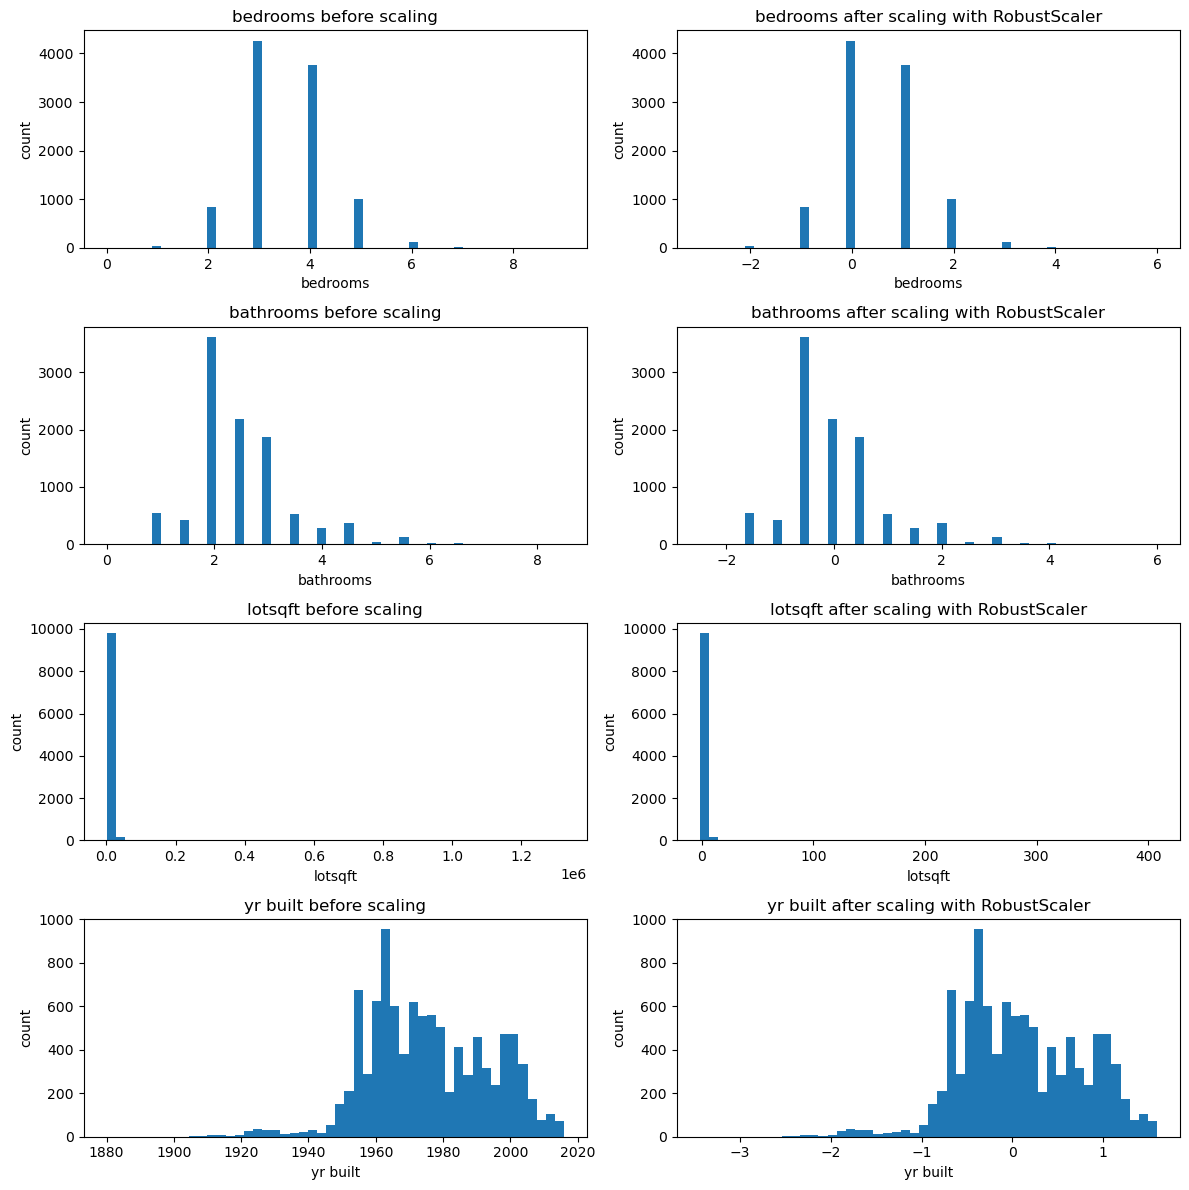

In [26]:
#Values Scaled

to_scale = ['bedrooms','bathrooms','lotsqft', 'yr built']
X_train, X_validate, X_test = acq.visualize_scaler(scaler=RobustScaler(), 
                 df=train, 
                 columns_to_scale=to_scale, 
                 bins=50,
                 X_validate = validate,
                 X_test = test)

In [27]:
#Established Baseline Prediciton absed on mean
baseline = y_train.mean()
baseline

value    584945.767409
dtype: float64

In [28]:
baseline_array = np.repeat(baseline, len(y_train))

In [29]:
X_train = X_train[to_scale]
X_train.head()

,bedrooms,bathrooms,lotsqft,yr built
46353,1.0,0.5,-0.369969,0.481481
48891,1.0,-0.5,-0.215170,-0.481481
39038,1.0,-0.5,0.651703,-0.407407
15156,0.0,-1.0,0.156347,-0.555556
42958,0.0,-0.5,-0.215170,-0.296296


       bedrooms  bathrooms   lotsqft  yr built
46353       1.0        0.5 -0.369969  0.481481
48891       1.0       -0.5 -0.215170 -0.481481
39038       1.0       -0.5  0.651703 -0.407407
15156       0.0       -1.0  0.156347 -0.555556
42958       0.0       -0.5 -0.215170 -0.296296
...         ...        ...       ...       ...
37385       0.0       -0.5 -0.215170 -0.222222
9711        0.0       -0.5 -0.215170 -0.185185
20975       0.0       -0.5  0.516099  0.666667
3532       -1.0       -1.5  0.047368 -1.259259
20711       0.0        0.0 -0.506192  0.518519

[10052 rows x 4 columns]


The best model is the poly model



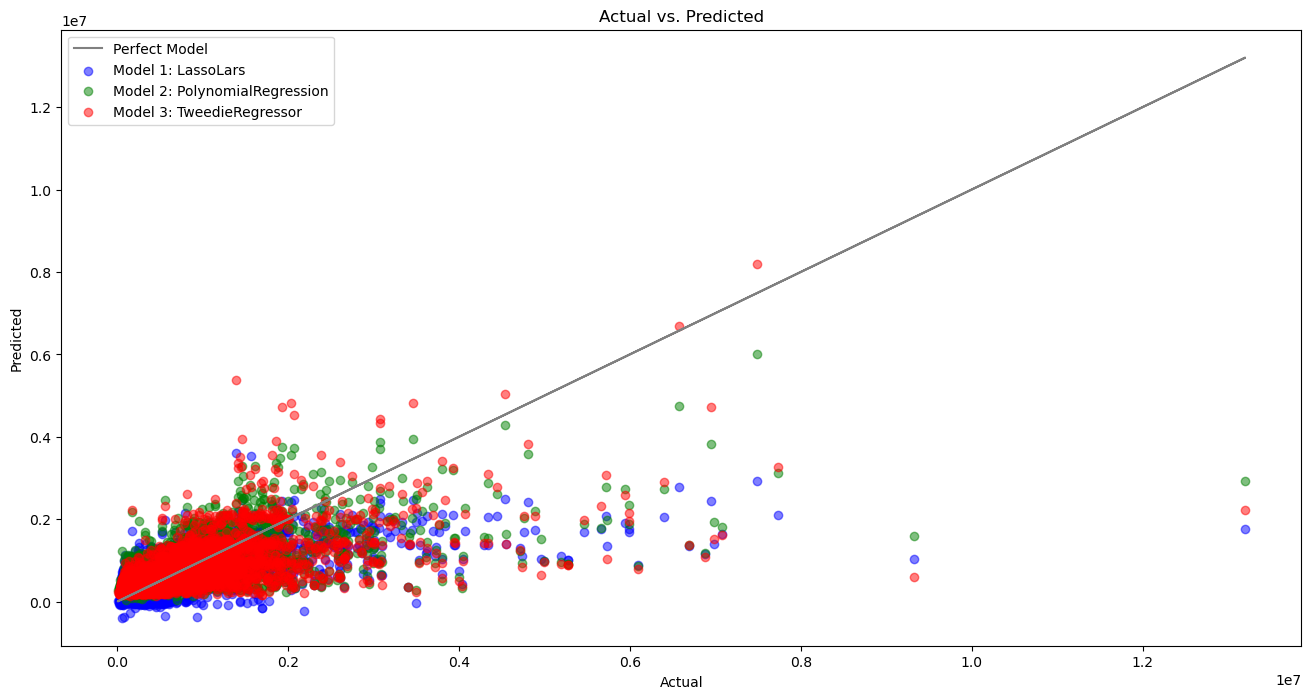

           model           RMSE       r^2
0  mean_baseline  573364.109763  0.000000
1          ols_1  457631.496933  0.362954
2          ols_2  454358.798014  0.372033
3           lars  454359.770245  0.372030
4           poly  423823.356543  0.453602
5            glm  438499.895978  0.415105


In [40]:


acq.auto_regress(y_train, X_train, X_train, X_train, y_train, X_test)


       bedrooms  bathrooms   lotsqft  yr built
46353       1.0        0.5 -0.369969  0.481481
48891       1.0       -0.5 -0.215170 -0.481481
39038       1.0       -0.5  0.651703 -0.407407
15156       0.0       -1.0  0.156347 -0.555556
42958       0.0       -0.5 -0.215170 -0.296296
...         ...        ...       ...       ...
37385       0.0       -0.5 -0.215170 -0.222222
9711        0.0       -0.5 -0.215170 -0.185185
20975       0.0       -0.5  0.516099  0.666667
3532       -1.0       -1.5  0.047368 -1.259259
20711       0.0        0.0 -0.506192  0.518519

[10052 rows x 4 columns]


The best model is the glm model



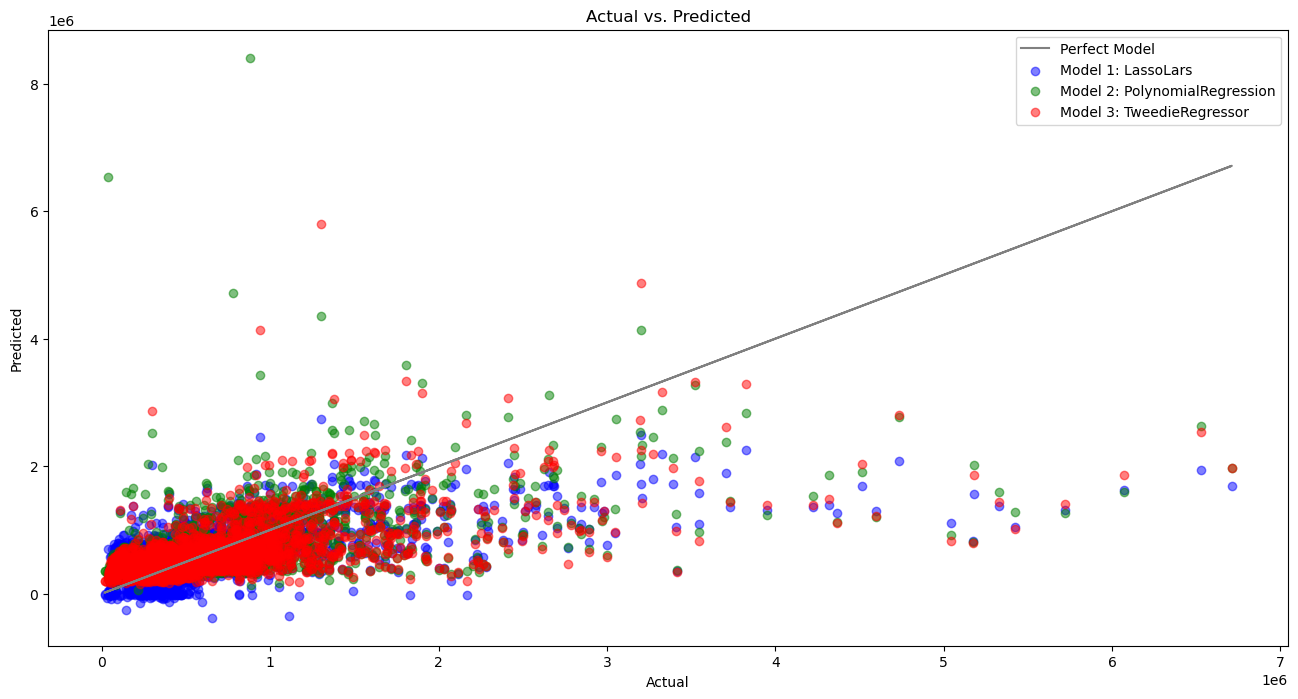

           model           RMSE       r^2
0  mean_baseline  573364.109763  0.000000
1          ols_1  433740.028365  0.355942
2          ols_2  428925.015890  0.370162
3           lars  428932.511589  0.370140
4           poly  445795.237969  0.319643
5            glm  421553.038607  0.391626


In [39]:


acq.auto_regress(y_train, X_train, X_train, X_validate, y_validate, X_test)



       bedrooms  bathrooms   lotsqft  yr built
46353       1.0        0.5 -0.369969  0.481481
48891       1.0       -0.5 -0.215170 -0.481481
39038       1.0       -0.5  0.651703 -0.407407
15156       0.0       -1.0  0.156347 -0.555556
42958       0.0       -0.5 -0.215170 -0.296296
...         ...        ...       ...       ...
37385       0.0       -0.5 -0.215170 -0.222222
9711        0.0       -0.5 -0.215170 -0.185185
20975       0.0       -0.5  0.516099  0.666667
3532       -1.0       -1.5  0.047368 -1.259259
20711       0.0        0.0 -0.506192  0.518519

[10052 rows x 4 columns]


The best model is the glm model



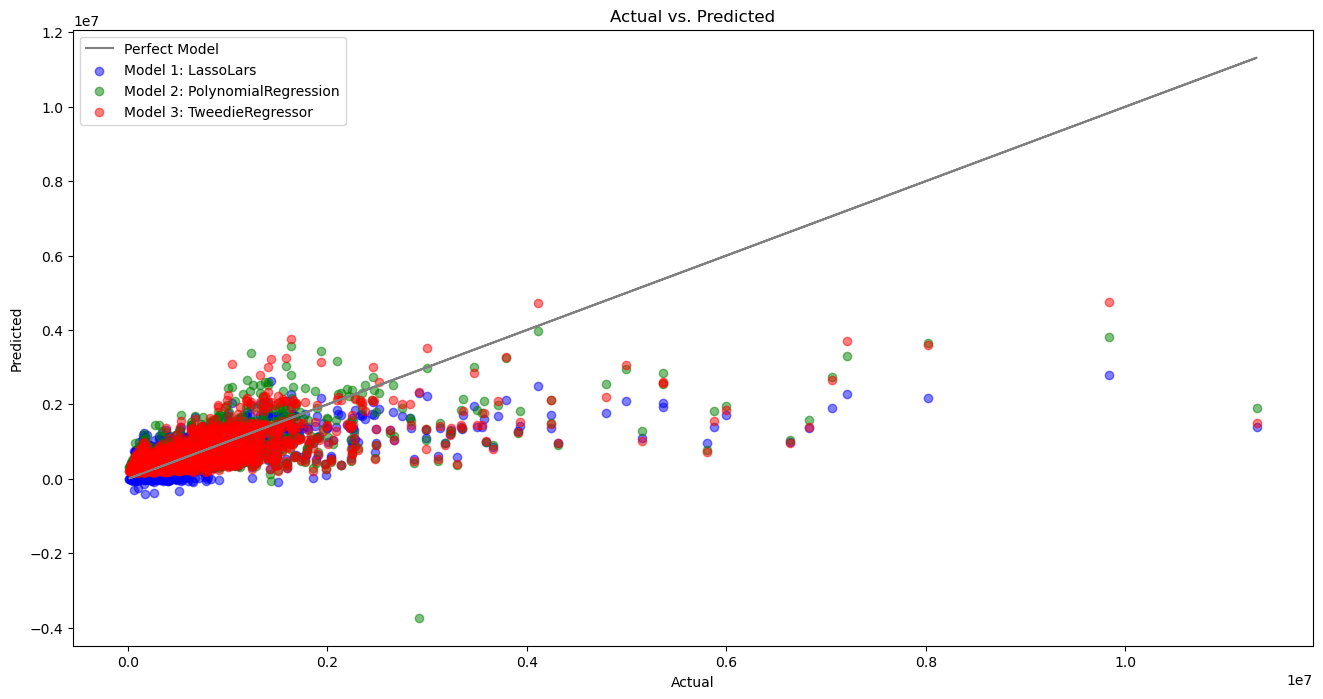

           model           RMSE       r^2
0  mean_baseline  573364.109763  0.000000
1          ols_1  508743.811918  0.342572
2          ols_2  503081.344120  0.357125
3           lars  503144.751055  0.356963
4           poly  484195.187441  0.404487
5            glm  473593.598705  0.430279


In [42]:
acq.auto_regress(y_train, X_train, X_train, X_test, y_test, X_test)


## Comparing models

All models were able to beat my baseline but GLM was my best model.

# Conclusions

### Exploration

Bedrooms, and square footage of the lot do

### Modeling Summary
- Polynomial Regression performed best on my train data set
   - RMSE 438499.89   
   - R2 of %41.5
- GLM was perfomred best on my validate set
    - RMSE 421553.038607  
    - R2 %39.2
- Generalized Linear Model performed performed best at on test
    - RMSE 473593.59 
    - R2 % 43.02

### Recommendations 

Gather data on average length of ownership of the home in the neighborhoods, and find out how satisfied the residents in those neighborhoods are with local city services and quantify that.

### Next Steps

Do additional analysis comparing combinations of features to find the highest association with value.